# Growth rate extraction

The following notebook allows to extract the growth rate from a Super lattice Kinetic Monte Carlo simulation with the mulskips code. It is supposed that you run mulskips for a flat (001) surface, that is "F" letter as input geometry in the file `start.dat` (see the tutorial to run the epitaxial growth of a surface with mulskips).

Firstly, let set the folder where you ran mulskips.
The script will extract the growth rate from the output \*.xyz files.

In [1]:
run_dir = '/Users/giuseppefisicaro/Documents/mulskips-check/surface/'

To calculate the growth rate we have to extract the surface height z$^{\text{surf}}_{\text{ave}}$ at different KMC steps and the running time $t$. Then the growth rate $\eta$ is

$$ \eta = \frac{\text{d} \text{z}^{\text{surf}}_{\text{ave}}}{\text{d}t}  $$

Let start with the determination of the surface height z$^{\text{surf}}_{\text{ave}}$ from a generic output file of the undercoordinated atoms.
To do that we divide the orthorhombic simulation box [x$_l$, y$_l$, z$_l$] in slices along the z-direction.
The size of each z-slice in angstroem is defined by the variable `bin_size`.
Essentially we are storing the z coordinates of all atoms in a histogram with bins of size `bin_size`.

In [2]:
bin_size = 5.0 # [Angstroem] size of the bins in the z direction to store all z-values in an histogram, 5 Angstroem should be ok

Then we check the slice along z which contains the largest number of atoms.
This z-slice corresponds in a first approximation to the region where the growing surface lies.
We calculate the average z coordinate z$_{\text{ave}}^{\text{largest-bin}}$ for atoms belonging to such z-slice.
Then we calculate z$^{\text{surf}}_{\text{ave}}$ as the average of the z-coordinate of all atoms falling in the range
$|z-z_{\text{ave}}^{\text{largest-bin}}| < \text{surface_roughness}$. To set the `surface_roughness` parameter it is recommended to have a look to the \*.xyz files by means of a visualization software to evaluate the extension/quality of the surface roughness. 

In [3]:
surface_roughness = 10.0 # [Angstroem] surface roughness in the z direction where average the surface height.

All the above operation to get z$^{\text{surf}}_{\text{ave}}$ for a given KMC xyz file are coded in the `get_surface_height` function.

In [4]:
# Main function of the notebook to get the surface height from a rough surface.
import numpy as np
def get_surface_height(filename,bin_size=5.0,surface_roughness=20.0):
    # bin_size [Angstroem] represents the size of the bins in the z direction to store all z-values in an histogram
    # surface_roughness [Angstroem] represents the surface roughness in the z direction where average the surface height
    with open (filename) as f:
        content = f.read().splitlines()
        line=content[0]
        splitline = line.split()
        nat = int(splitline[0]) # Total number of atoms
        #print('nat: {}'.format(nat))
        line=content[1]
        splitline = line.split()
        bc=str(splitline[0])
        xl=float(splitline[1])
        yl=float(splitline[2])
        zl=float(splitline[3])
        #print(zl)
        lines=content[2:]
        all_z_values = []
        for line in lines:
            splitline = line.split()
            at=str(splitline[0])
            x=float(splitline[1])
            y=float(splitline[2])
            z=float(splitline[3])
            all_z_values.append(z)
        #print(all_z_values)
        #print(min(all_z_values))
        #print(max(all_z_values))
        z_range = max(all_z_values) - min(all_z_values)
        if len(all_z_values) != nat:
            print('error: nat and len(all_z_values) do not coincide')
        databins=int(zl/bin_size)
        #print(databins)
        hist = np.histogram(all_z_values,bins=databins,range=(0.0, zl))
        #print(hist[0])
        maxIndexList = [i for i,j in enumerate(hist[0]) if j==max(hist[0])] #here,i=index and j = value of that index
        #print(maxIndexList[0])
        #print(hist[0][maxIndexList])
        z_min = float(bin_size * maxIndexList[0])
        z_max = float(z_min + bin_size)

        # average of z-value within the bin with maximum number of elements
        count = 0
        z_sum = 0.0
        for z in all_z_values:
            if z > z_min and z < z_max:
                count+=1
                z_sum = z_sum + z 
        z_ave = float(z_sum/count)
        #print(z_ave)
        
        # average of z-value for atoms falling in the range (z_ave-surface_roughness,z_ave+surface_roughness)
        count = 0
        z_sum = 0.0
        z_min = z_ave - surface_roughness
        z_max = z_ave + surface_roughness
        for z in all_z_values:
            if z > z_min and z < z_max:
                count+=1
                z_sum = z_sum + z 
        z_ave = float(z_sum/count)
        #print(z_ave)   
    return z_ave

Then we need to collect all the output \*.xyz files from the mulskips run.

In [5]:
# Collect all *.xyz files within the run_dir directory related to the undercoordinated atoms,
# that are the files I00000000.xyz, I00000001.xyz etc ...
import os
files_list = os.listdir(run_dir)
files_list.sort()

# Un comment these lines if you want to list all files in the directory 'run_dir'
#print('All files are:')
#print(files_list)
#print('')

undercoordinated_atoms = []
for file in files_list:
    if file[-3:] == 'xyz':
        if file[-5].isnumeric():
            undercoordinated_atoms.append(file)

#for ele in undercoordinated_atoms:
#    print(ele)

Here we calculate and store the surface height for all output files.

In [6]:
all_surface_heights = []
for file in undercoordinated_atoms:
    filename = run_dir+file
    surface_height = get_surface_height(filename)
    all_surface_heights.append(surface_height)
#print(all_surface_heights)

Here we plot the surface height as a z$^{\text{surf}}_{\text{ave}}$ as function of the KMC steps.

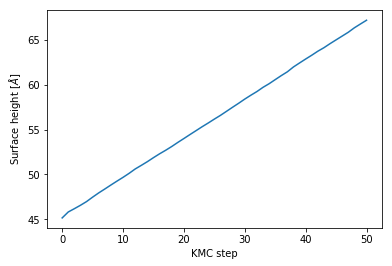

In [7]:
import matplotlib.pyplot as plt
plt.plot(all_surface_heights)
plt.xlabel('KMC step')
plt.ylabel('Surface height [$\AA$]')
plt.show()

Here we extract the KMC time from the run output.
When you run the mulskips code please store the screen output in the file log.txt:

`<path-of-the-compiled-code>/mulskips.e` | tee log.txt

In [8]:
def get_time(filename):
    with open (filename) as f:
        content = f.read().splitlines()
        line=content[0]
        splitline = line.split()
        time = float(splitline[3]) # Total number of atoms
    return time

In [9]:
kmc_time_list = []
for file in undercoordinated_atoms:
    filename = run_dir+file
    time = get_time(filename)
    kmc_time_list.append(time)
#print(kmc_time_list)

Here we have to convert the KMC time in the real process time. That depends on the calibration strategy.
A reasonable rescale can be obtained with a constant jump frequency $\nu = 10^{-12}$ s.

In [10]:
nu = 1.0e-12 # jump frequency

In [11]:
time_list = [i * nu for i in kmc_time_list]

Here we plot the surface height as a z$^{\text{surf}}_{\text{ave}}$ as function of the procee time.

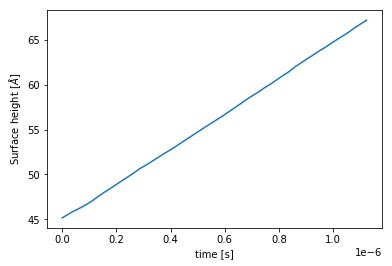

In [12]:
plt.plot(time_list,all_surface_heights)
plt.xlabel('time [s]')
plt.ylabel('Surface height [$\AA$]')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.show()

In [13]:
def get_growth_rate(time_list,all_surface_heights):
    gr = []
    dx = all_surface_heights[1] - all_surface_heights[0]
    dt = time_list[1] - time_list[0]
    curr_gr = dx / dt
    gr.append(curr_gr)
    for ind in range(len(time_list)-2):
        ind = ind+1
        dx = all_surface_heights[ind+1] - all_surface_heights[ind-1]
        dt = time_list[ind+1] - time_list[ind-1]
        curr_gr = dx / dt
        gr.append(curr_gr)
    dx = all_surface_heights[-1] - all_surface_heights[-2]
    dt = time_list[-1] - time_list[-2]
    curr_gr = dx / dt
    gr.append(curr_gr)
    return gr

In [14]:
growth_rate = get_growth_rate(time_list,all_surface_heights)

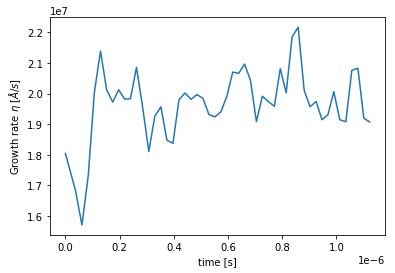

In [15]:
plt.plot(time_list,growth_rate)
plt.xlabel('time [s]')
plt.ylabel('Growth rate $\eta$ [${\AA}/s$]')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.show()